<h1 style="color:red;"> Notebeook du [TEST] Synthetic big patent Similarity</h1> 

### Importation des librairies

In [1]:
# === Installation des dépendances nécessaires ===
# Décommentez les lignes ci-dessous si vous exécutez ce notebook pour la première fois
# ou dans un environnement n'ayant pas encore les bibliothèques installées.

# !pip install sentence_transformers   # Pour les modèles de type Sentence-BERT et l'entraînement avec Trainer
# !pip install accelerate              # Optimisation de l'entraînement multi-GPU/TPU (utilisé par Hugging Face)
# !pip install datasets                # Chargement, gestion et transformation de jeux de données (Hugging Face)
# !pip install wandb                   # Suivi des expériences (facultatif mais recommandé pour le logging)

In [2]:
# === Chargement des variables d'environnement ===
# Utilise un fichier `.env` pour stocker en toute sécurité les clés API, chemins, ou autres paramètres sensibles.
# Assurez-vous qu'un fichier .env est présent à la racine du projet.

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# === Imports standards ===
from typing import Optional

import torch  

# === Gestion et chargement des jeux de données ===
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets  # Bibliothèque Hugging Face 'datasets'

# === Sentence-Transformers (modèles de type BERT optimisés pour les embeddings) ===
from sentence_transformers import (
    SentenceTransformer,                        
    SentenceTransformerTrainer,                
    SentenceTransformerTrainingArguments,      
)

from sentence_transformers.evaluation import TripletEvaluator  # Évaluateur basé sur des triplets (anchor, positive, negative)
from sentence_transformers.losses import TripletLoss           # Fonction de perte pour apprentissage par triplets

# === (Optionnel) Optimisation fine avec Transformers ===
# from transformers import get_linear_schedule_with_warmup     # Scheduler d'apprentissage avec warmup
# from torch.optim import AdamW                                # Optimiseur adapté aux Transformers


In [4]:
# Permet d'assurer que les résultats sont cohérents entre différentes exécutions, en fixant les sources d'aléatoire.
seed = 42
torch.cuda.manual_seed_all(seed)       # Pour les opérations sur GPU (si disponible)

### Classes

In [5]:
class Model:
    def __init__(self, model_name: str, model_path: Optional[str] = "avsolatorio/GIST-small-Embedding-v0"):
        """
        Initialise le modèle SentenceTransformer.

        :param model_name: Nom de l'expérience modèle (utilisé pour le logging et le nommage)
        :param model_path: Chemin ou identifiant HuggingFace du modèle pré-entraîné
        """
        self.name = model_name
        self.model = SentenceTransformer(model_path)

    def __call__(self):
        return self.model

    def training(self, train_test: DatasetDict, **kwargs):
        """
        Fonction d'entraînement du modèle.

        :param train_test: Dictionnaire contenant les jeux de données 'train', 'valid' et 'test' (avec triplets anchor, positive, negative)
        :param kwargs: Arguments supplémentaires pour la configuration de l'entraînement (batch_size, num_train_epochs, etc.)
        """
        # Configuration des arguments d'entraînement
        args = SentenceTransformerTrainingArguments(
            output_dir="models/checkpoints",
            logging_dir="./logs",
            logging_steps=20,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="eval_cosine_accuracy",
            greater_is_better=True,
            eval_strategy="epoch",
            save_strategy="epoch",
            fp16=False,
            bf16=True,
            run_name=f"{self.name}_experiment",
            seed=42,
            **kwargs
        )

        # Définition de l'évaluateur pour la validation
        dev_evaluator = TripletEvaluator(
            anchors=train_test["valid"]["anchor"],
            positives=train_test["valid"]["positive"],
            negatives=train_test["valid"]["negative"]
        )

        # Définition de la fonction de perte
        loss = TripletLoss(self.model)

        # Instanciation du Trainer
        trainer = SentenceTransformerTrainer(
            model=self.model,
            args=args,
            train_dataset=train_test["train"],
            eval_dataset=train_test["valid"],
            loss=loss,
            evaluator=dev_evaluator,
            # optimizers=(optimizer, scheduler),  # Optionnel : à activer si personnalisation
        )

        # Démarrage de l'entraînement
        trainer.train()

    def testing(self, dataset: DatasetDict) -> float:
        """
        Fonction pour tester le modèle sur un dataset de test.

        :param dataset: Dictionnaire contenant les triplets (anchor, positive, negative)
        :return: Résultat de l'évaluation
        """
        test_evaluator = TripletEvaluator(
            anchors=dataset["anchor"],
            positives=dataset["positive"],
            negatives=dataset["negative"],
            name=f"{self.name}_test",
        )
        
        return test_evaluator(self.model)


### 📉 Fonction de Perte : Triplet Loss avec Similarité Cosinus

La fonction de perte utilisée est une **Triplet Loss**, adaptée aux tâches de similarité sémantique.

#### 🔍 Objectif :
Minimiser la distance entre l’ancre (*anchor*) et un exemple similaire (*positive*), 
tout en maximisant la distance avec un exemple différent (*negative*).

#### 🧮 Formule :
$$
\text{Loss} = \max \left(0, \; d(a, p) - d(a, n) + \text{margin} \right)
$$

- \( a \): vecteur de l’ancre (*anchor*)
- \( p \): vecteur de l’exemple similaire (*positive*)
- \( n \): vecteur de l’exemple différent (*negative*)
- \( d(x, y) \): **distance cosinus** par défaut : 
  $$
  d(x, y) = 1 - \cos(\theta) = 1 - \frac{x \cdot y}{\|x\|\|y\|}
  $$
- **margin** : marge souhaitée entre les distances (ex: 0.2)

#### 📐 Pourquoi la Similarité Cosinus ?
Elle est efficace pour des vecteurs normalisés comme les embeddings textuels, 
par mesure l’orientation.


### GPU disponible ?

In [6]:
# Vérifier si un GPU est disponible
print("GPU disponible :", torch.cuda.is_available())

# Nom du GPU
if torch.cuda.is_available():
    print("Nom du GPU :", torch.cuda.get_device_name(0))


GPU disponible : True
Nom du GPU : NVIDIA GeForce RTX 3050 Laptop GPU


## Chargement du jeu de données BigPatent

In [7]:
# Chargement du dataset à partir d’un fichier JSON local contenant (ancre, query, positif, négatif).
data = load_dataset("json", data_files="dataset_big_patent_v3.json")

In [8]:
# Suppression de l’ancienne colonne 'anchor' 
dataset = data.remove_columns('anchor')

# Renommage de la colonne 'query' en 'anchor' pour correspondre au format attendu par le modèle training
dataset = dataset.rename_column('query', 'anchor')

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive', 'negative'],
        num_rows: 499
    })
})

In [10]:
dataset["train"]["anchor"][0]

'What are the key advantages and applications of an implantable stimulator system that uses a passive magnetostrictive electroactive sensor for power harvesting in a non-vibration rich environment?,'

## Zero-shot et fine tuning

In [12]:
# Instanciation d’un modèle de référence sans fine-tuning.
# Il sera utilisé pour évaluer la qualité des triplets initiaux (baseline).
model_zero = Model("zero_shot_model")

### Refonte du dataset pour l'entrainement

In [13]:
# Initialisation des listes de succès et d'échecs selon les scores de similarité
success = []
failure = []

# Boucle sur les triplets du dataset d'entraînement
for ligne in dataset["train"]:
    # Extraction des trois éléments du triplet : ancre, positif, négatif
    observation = [ligne["anchor"], ligne["positive"], ligne["negative"]]
    
    # Génération des embeddings via le modèle de référence (non fine-tuné)
    embeddings = model_zero().encode(observation, convert_to_tensor=True)
    
    # Calcul de la similarité cosinus entre les différentes paires
    similarities = model_zero().similarity(embeddings, embeddings)
    
    # Comparaison : si l’ancre est plus proche du positif que du négatif, c’est un succès
    if similarities[0][1] > similarities[0][2]:
        success.append(ligne)
    else:
        failure.append(ligne)

In [15]:
len(failure), len(success) 

(136, 363)

In [16]:
# Création des datasets individuels à partir des listes `success` et `failure`,
# puis mélange aléatoire pour éviter les biais de position.
success_dataset = Dataset.from_list(success).shuffle(seed=42)
failure_dataset = Dataset.from_list(failure).shuffle(seed=42)

# Définition des ratios de séparation pour les ensembles d'entraînement et de validation.
# On envoie 50% des succès dans l'entraînement (soit 30% du total initial si succès = 60%),
# et on conserve 85% des échecs pour l'entraînement.
success_ratio = 0.5
failure_ratio = 0.85

# Découpage du dataset des succès en train/valid
success_split_idx = int(success_ratio * len(success_dataset))
success_for_train = success_dataset.select(range(success_split_idx))
success_for_valid = success_dataset.select(range(success_split_idx, len(success_dataset)))

# Découpage du dataset des échecs en train/valid
failure_split_idx = int(failure_ratio * len(failure_dataset))
failure_for_train = failure_dataset.select(range(failure_split_idx))
failure_for_valid = failure_dataset.select(range(failure_split_idx, len(failure_dataset)))

# Fusion des sous-datasets pour créer les ensembles finaux d'entraînement et de validation.
train_dataset = concatenate_datasets([failure_for_train, success_for_train])
valid_dataset = concatenate_datasets([failure_for_valid, success_for_valid])

# Construction du dictionnaire final contenant les splits de données
# "train", "valid" (et "test" hérité du dataset original)
train_test = DatasetDict({
    "train": train_dataset,
    "valid": valid_dataset,
    "test": dataset["train"]  # Le test set est conservé tel quel depuis le jeu original
})

train_test


DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive', 'negative'],
        num_rows: 296
    })
    valid: Dataset({
        features: ['anchor', 'positive', 'negative'],
        num_rows: 203
    })
    test: Dataset({
        features: ['anchor', 'positive', 'negative'],
        num_rows: 499
    })
})

### Evaluation en zero shot

In [61]:
train_zero = model_zero.testing(train_test["train"])["zero_shot_model_test_cosine_accuracy"]
train_zero

0.6114864945411682

In [62]:
valid_zero = model_zero.testing(train_test["valid"])["zero_shot_model_test_cosine_accuracy"]
valid_zero

0.8965517282485962

In [63]:
test_zero = model_zero.testing(train_test["test"])["zero_shot_model_test_cosine_accuracy"]
test_zero

0.7274549007415771

### Entrainement du modèle

In [20]:
model_1 = Model("model_1arg")

In [21]:
# Dictionnaire des arguments d'entraînement pour SentenceTransformerTrainingArguments.

args = {
    "num_train_epochs": 10,                 # Nombre total d'époques d'entraînement
    "per_device_train_batch_size": 16,      # Taille du batch pour l'entraînement
    "per_device_eval_batch_size": 10,       # Taille du batch pour l'évaluation (valid/test)
    "learning_rate": 1e-5,                  # Taux d'apprentissage 
}


In [22]:
model_1.training(train_test,**args)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: toaly-samuel-boris-tan (toaly-samuel-boris-tan-efrei) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Cosine Accuracy
1,No log,4.808261,0.876847
2,4.914600,4.786403,0.837438
3,4.889200,4.766803,0.827586
4,4.881100,4.751766,0.812808
5,4.833600,4.738719,0.798030
6,4.834700,4.730022,0.788177
7,4.817800,4.722884,0.778325
8,4.801300,4.718532,0.768473
9,4.783800,4.715669,0.768473
10,4.794000,4.714672,0.758621


### Résultats

In [55]:
train_tuned = model_1.testing(train_test["train"])["model_1arg_test_cosine_accuracy"]
train_tuned

0.6452702879905701

In [56]:
valid_tuned = model_1.testing(train_test["valid"])["model_1arg_test_cosine_accuracy"]
valid_tuned

0.8768472671508789

In [57]:
test_tuned = model_1.testing(train_test["test"])["model_1arg_test_cosine_accuracy"]
test_tuned

0.7374749779701233

### Sauvegarde du modèle

In [68]:
# sauvegarde du model
#model_1.save_pretrained("models/final")

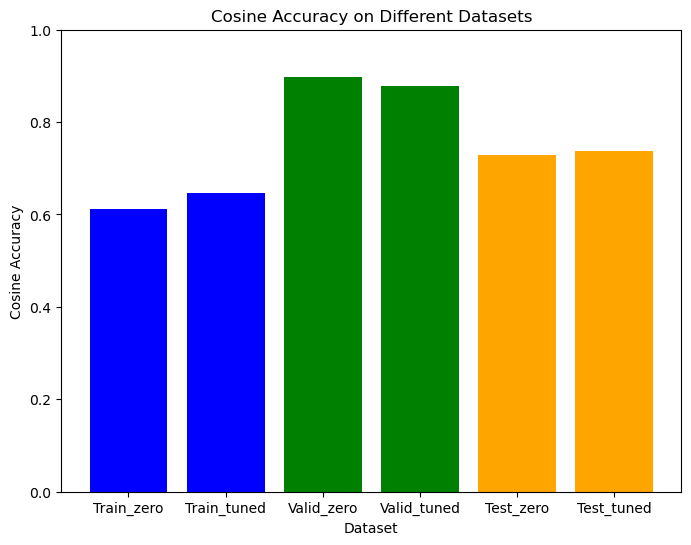

In [67]:
import matplotlib.pyplot as plt

# Cosine accuracy scores for each dataset
abscisse = ['Train_zero', 'Train_tuned', 'Valid_zero',"Valid_tuned","Test_zero","Test_tuned",]
accuracies = [train_zero, train_tuned, valid_zero, valid_tuned, test_zero, test_tuned]

# Create a bar chart to visualize the accuracies
plt.figure(figsize=(8, 6))
plt.bar(abscisse, accuracies, color=['blue','blue', 'green', 'green', 'orange', 'orange'])
plt.title('Cosine Accuracy on Different Datasets')
plt.xlabel('Dataset')
plt.ylabel('Cosine Accuracy')
plt.ylim(0, 1)

# Show the plot
plt.show()
